In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import re

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.probability import FreqDist
from textblob import TextBlob
import os

# Data fetching

In [2]:
data_path = './data_yelp/raw/json/yelp_academic_dataset_review.json'

# Reading the first line of the review dataset json
with open(data_path) as f:
    first_line = f.readline()
    print(first_line)

FileNotFoundError: [Errno 2] No such file or directory: './data_yelp/raw/json/yelp_academic_dataset_review.json'

In [3]:
from data_preprocesser import split_raw_csv_review_file

split_raw_csv_review_file(lines_per_file = 1000000, single_file=True, join_business=True)

In [4]:
small_data_path = './data_yelp/preprocessed/yelp_academic_dataset_review_split/yelp_academic_dataset_review_1000000.csv'
data_df = pd.read_csv(small_data_path)

data_df.head()

,Unnamed: 0,review_id,business_id,stars_x,stars_y,date,city,text,categories
0,0,vkVSCC7xljjrAI4UGfnKEQ,AEx2SYEUJmTxVVB18LlCwA,5,4.0,2016-05-28,Montréal,Super simple place but amazing nonetheless. It...,Diners;Food;Restaurants;Delis
1,1,n6QzIUObkYshz4dz2QRJTw,VR6GpWIda3SfvPC-lg9H3w,5,4.5,2016-05-28,Montréal,Small unassuming place that changes their menu...,Restaurants;Canadian (New);Italian
2,2,MV3CcKScW05u5LVfF6ok0g,CKC0-MOWMqoeWf6s-szl8g,5,4.0,2016-05-28,Outremont,Lester's is located in a beautiful neighborhoo...,Specialty Food;Food;Sandwiches;Restaurants;Bur...
3,3,IXvOzsEMYtiJI0CARmj77Q,ACFtxLv8pGrrxMm6EgjreA,4,3.5,2016-05-28,Montréal,Love coming here. Yes the place always needs t...,Fast Food;Restaurants;Burgers
4,4,L_9BTb55X0GDtThi6GlZ6w,s2I_Ni76bjJNK9yG60iD-Q,4,4.5,2016-05-28,Montréal,Had their chocolate almond croissant and it wa...,Bakeries;Restaurants;Food;Sandwiches;Cafes;Cof...


# Data Analysis

In [5]:
# Analyse du dataset
categories_df = data_df.set_index('review_id')['categories'].str.get_dummies(';')

KeyboardInterrupt: 

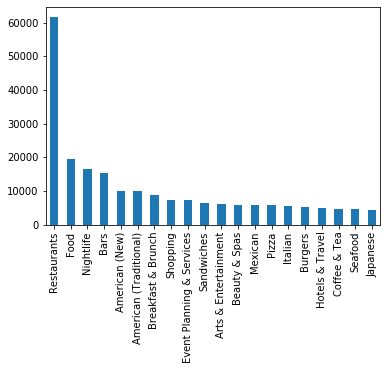

In [6]:
categories_df_head = categories_df.sum().sort_values(ascending=False)[:20]
categories_df_head.plot.bar()
plt.show()

In [7]:
threshold = 5000

# On garde : Restaurants, Bars, Shopping, Arts & Entertainment
business_types = {
    "Restaurants" : pd.DataFrame(), 
    "Bars" : pd.DataFrame(), 
    "Shopping" : pd.DataFrame(), 
    "Arts & Entertainment" : pd.DataFrame(), 
    "Hotels & Travel" : pd.DataFrame()
}

categories_df.loc[:,'Total'] = categories_df.sum(axis=1)

for business_type in business_types:
    review_ids = categories_df[categories_df[business_type]==1].sort_values(by=['Total'], ascending=True)[:threshold].index.values.tolist()
    df = data_df[data_df['review_id'].isin(review_ids)]
    business_types[business_type] = df
    

# Data processing

In [8]:
# Processing Functions
from textblob import TextBlob 




tags = ['FW','JJ','JJR','JJS','NN','NNS','NNP','NNPS','RBR','RBS','UH','VB','VBD','VBG','VBN','VBP','VBZ']



def identify_tokens(row):
    review = row['text']
    tokens = nltk.word_tokenize(review)
    # taken only words (not punctuation)
    # token_words = [re.sub("[^\w\s]", " ", w) for w in tokens]
    token_words = [w for w in tokens if w.isalpha()]
    return token_words

stops = set(stopwords.words("english"))                  

def remove_stops(row):
    my_list = row['words']
    meaningful_words = [w for w in my_list if not w in stops and w != " "]
    return (meaningful_words)

stemming = PorterStemmer()

### Garder juste les noms, verbes, adjectifs et interjections

def select_tagged(row):
    my_list = row['words_meaningful']
    tagged_words = nltk.pos_tag(my_list)
    useful_words = [w[0] for w in tagged_words if w[1] in tags]
    return useful_words
    

### Enlever les mots trops polarisés 

def unpolarized(row):
    my_list = row['useful_words']
    unpolarized_words = [w for w in my_list if abs(TextBlob(w).sentiment.polarity)<0.2]
    return unpolarized_words
    

    

def stem_list(row):
    my_list = row['words_meaningful']
    stemmed_list = [stemming.stem(word) for word in my_list]
    return (stemmed_list)

lemming = WordNetLemmatizer()

def lem_list(row):
    my_list = row['words_meaningful']
    lemmed_list = [lemming.lemmatize(word) for word in my_list]
    return (lemmed_list)

def rejoin_words(row):
    my_list = row['stemmed_words']
    joined_words = ( " ".join(my_list))
    return joined_words

In [9]:
def process(data_df):
    data_df['text'] = data_df['text'].str.lower()
    data_df['words'] = data_df.apply(identify_tokens, axis=1)
    data_df['words_meaningful'] = data_df.apply(remove_stops, axis=1)
    data_df['stemmed_words'] = data_df.apply(stem_list, axis=1)
    data_df['lemmed_words'] = data_df.apply(lem_list, axis=1)
    data_df['processed'] = data_df.apply(rejoin_words, axis=1)
    return data_df

In [10]:
processed_business_types = {
    "Restaurants" : pd.DataFrame(), 
    "Bars" : pd.DataFrame(), 
    "Shopping" : pd.DataFrame(), 
    "Arts & Entertainment" : pd.DataFrame(), 
    "Hotels & Travel" : pd.DataFrame()
}

for business_type, df in business_types.items():
    df = process(df)
    processed_business_types[business_type] = df

/home/arthur/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/arthur/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/arthur/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

# Post Processing Analysis

In [11]:
def analysis(data_df, title, words):
    all_words = sum(data_df[words], [])
    fdist = FreqDist(all_words)
    fdist.plot(30, cumulative=False, title=title)
    fdist.plot(100, cumulative=False, title=title)
    plt.show()

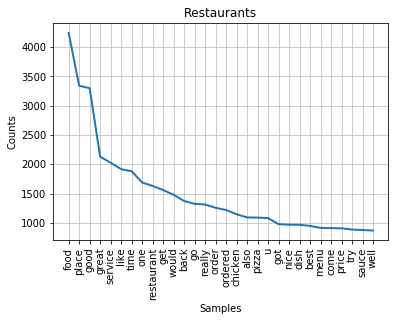

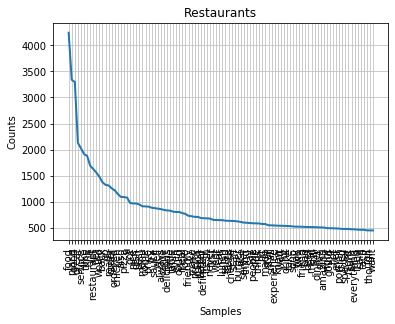

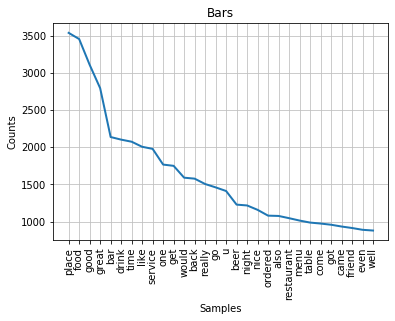

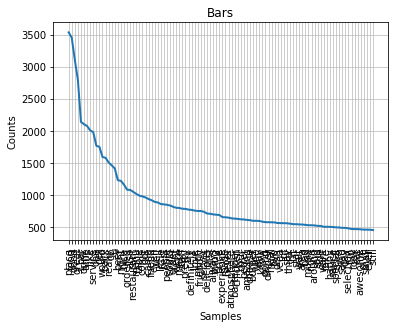

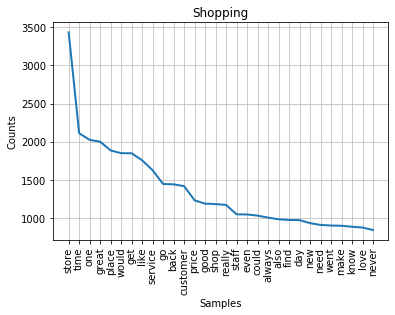

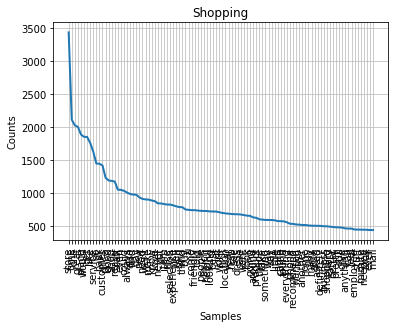

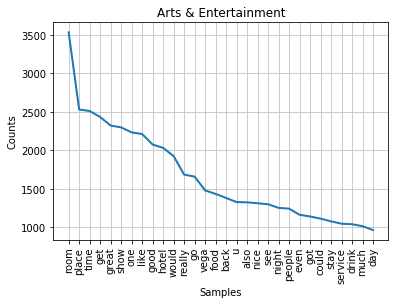

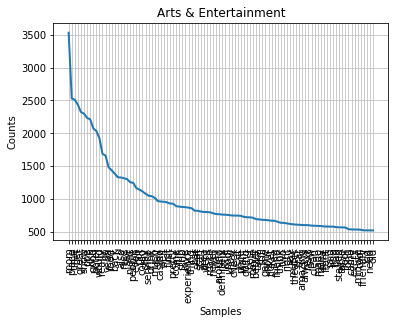

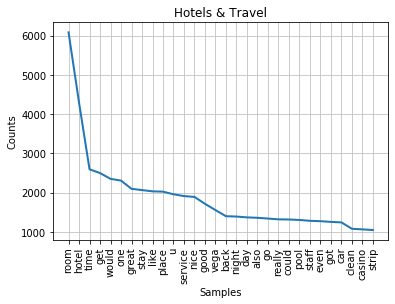

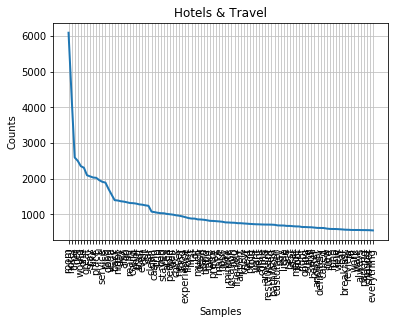

In [12]:
# use 'lemmed_words' or 'stemmed_words'
for business_type, df in processed_business_types.items():
    analysis(df, business_type, 'lemmed_words')

# Test Word2Vec

In [255]:
from gensim.models import Word2Vec

In [256]:
review_ids = categories_df[categories_df['Restaurants']==1].index.values.tolist()
df = data_df[data_df['review_id'].isin(review_ids)]
df = process(df)
df

/home/arthur/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/arthur/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/arthur/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

,Unnamed: 0,review_id,business_id,stars_x,stars_y,date,city,text,categories,words,words_meaningful,stemmed_words,lemmed_words,processed
0,0,vkVSCC7xljjrAI4UGfnKEQ,AEx2SYEUJmTxVVB18LlCwA,5,4.0,2016-05-28,Montréal,super simple place but amazing nonetheless. it...,Diners;Food;Restaurants;Delis,"[super, simple, place, but, amazing, nonethele...","[super, simple, place, amazing, nonetheless, a...","[super, simpl, place, amaz, nonetheless, aroun...","[super, simple, place, amazing, nonetheless, a...",super simpl place amaz nonetheless around sinc...
1,1,n6QzIUObkYshz4dz2QRJTw,VR6GpWIda3SfvPC-lg9H3w,5,4.5,2016-05-28,Montréal,small unassuming place that changes their menu...,Restaurants;Canadian (New);Italian,"[small, unassuming, place, that, changes, thei...","[small, unassuming, place, changes, menu, ever...","[small, unassum, place, chang, menu, everi, of...","[small, unassuming, place, change, menu, every...",small unassum place chang menu everi often coo...
2,2,MV3CcKScW05u5LVfF6ok0g,CKC0-MOWMqoeWf6s-szl8g,5,4.0,2016-05-28,Outremont,lester's is located in a beautiful neighborhoo...,Specialty Food;Food;Sandwiches;Restaurants;Bur...,"[lester, is, located, in, a, beautiful, neighb...","[lester, located, beautiful, neighborhood, sin...","[lester, locat, beauti, neighborhood, sinc, kn...","[lester, located, beautiful, neighborhood, sin...",lester locat beauti neighborhood sinc known sm...
3,3,IXvOzsEMYtiJI0CARmj77Q,ACFtxLv8pGrrxMm6EgjreA,4,3.5,2016-05-28,Montréal,love coming here. yes the place always needs t...,Fast Food;Restaurants;Burgers,"[love, coming, here, yes, the, place, always, ...","[love, coming, yes, place, always, needs, floo...","[love, come, ye, place, alway, need, floor, sw...","[love, coming, yes, place, always, need, floor...",love come ye place alway need floor swept give...
4,4,L_9BTb55X0GDtThi6GlZ6w,s2I_Ni76bjJNK9yG60iD-Q,4,4.5,2016-05-28,Montréal,had their chocolate almond croissant and it wa...,Bakeries;Restaurants;Food;Sandwiches;Cafes;Cof...,"[had, their, chocolate, almond, croissant, and...","[chocolate, almond, croissant, amazing, light,...","[chocol, almond, croissant, amaz, light, butte...","[chocolate, almond, croissant, amazing, light,...",chocol almond croissant amaz light butteri oh ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99993,99993,EZG7kPK-jUFTzCFRp01oaw,06graki4XxJJJp5b8H9aGg,4,3.0,2011-10-31,Charlotte,"delicious breakfast food, great service and a ...",Breakfast & Brunch;Restaurants,"[delicious, breakfast, food, great, service, a...","[delicious, breakfast, food, great, service, f...","[delici, breakfast, food, great, servic, fun, ...","[delicious, breakfast, food, great, service, f...",delici breakfast food great servic fun atmosph...
99994,99994,RpT1GVVIYC5NZQmsCnUS8Q,SThmy10YhS13oFgT990Xhw,5,4.0,2013-12-28,Charlotte,amazing warm waffles at a very reasonable pric...,Breakfast & Brunch;Coffee & Tea;Restaurants;Food,"[amazing, warm, waffles, at, a, very, reasonab...","[amazing, warm, waffles, reasonable, price, tr...","[amaz, warm, waffl, reason, price, tradit, nut...","[amazing, warm, waffle, reasonable, price, tra...",amaz warm waffl reason price tradit nutella fr...
99996,99996,UM9Xf3ExrVIfK0a4DbtSVA,dHUb949NckE2GqtlSVlWQg,5,4.5,2013-03-04,Charlotte,loved the korean bbq special sandwich with cil...,Street Vendors;Soul Food;Food;Restaurants;Pers...,"[loved, the, korean, bbq, special, sandwich, w...","[loved, korean, bbq, special, sandwich, cilant...","[love, korean, bbq, special, sandwich, cilantr...","[loved, korean, bbq, special, sandwich, cilant...",love korean bbq special sandwich cilantro yumm...
99998,99998,JMHSEhNN42SiM3mVhUzc9A,zr8Ojsm-yNhvfTzBzcKU9w,3,4.5,2016-02-27,Charlotte,i had the santorini breakfast crepe with olive...,Specialty Food;Coffee & Tea;Creperies;Breakfas...,"[i, had, the, santorini, breakfast, crepe, wit...","[santorini, breakfast, crepe, olives, spinach,...","[santorini, breakfast, crepe, oliv, spinach, f...","[santorini, breakfast, crepe, olive

In [258]:
model = Word2Vec(df['lemmed_words'], min_count=1, size= 50,workers=3, window=3)

In [259]:
model.most_similar('service')[:10]

/home/arthur/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning:

Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).



[('consistently', 0.7254382371902466),
 ('staff', 0.6468449831008911),
 ('value', 0.6291279196739197),
 ('job', 0.6243668794631958),
 ('waitstaff', 0.6112637519836426),
 ('generally', 0.6088790893554688),
 ('lonzo', 0.608417809009552),
 ('consistent', 0.6007542014122009),
 ('atmosphere', 0.5984443426132202),
 ('food', 0.5938060283660889)]

In [260]:
X = model[model.wv.vocab]
X

/home/arthur/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).



array([[ 2.1869035e-01, -1.9657673e+00,  1.8090049e+00, ...,
         2.3912258e+00, -2.0417066e-01,  5.9866583e-01],
       [ 3.8309658e-01, -1.1897428e+00, -5.3886551e-01, ...,
         9.3468517e-01, -1.2331803e+00, -9.8120183e-01],
       [-9.0653038e-01,  1.5139588e+00,  6.9503152e-01, ...,
         1.7846413e-01, -1.3452350e-01, -3.1206107e+00],
       ...,
       [-1.6669614e-02, -4.5316454e-02, -4.2846040e-03, ...,
        -9.7863013e-03, -2.4490347e-02, -1.7238991e-02],
       [ 1.0475177e-02, -2.6522914e-02, -6.7846566e-03, ...,
        -1.0518902e-02,  1.1157554e-03, -1.4079645e-02],
       [ 8.4192464e-03, -2.4147104e-02, -1.0951354e-02, ...,
         2.6475200e-02,  1.2959878e-02, -2.1542421e-02]], dtype=float32)

## Plot Word Vectors Using PCA

In [261]:
from sklearn.decomposition import TruncatedSVD

tsvd = TruncatedSVD(n_components=5, n_iter=10)
result = tsvd.fit_transform(X)

In [262]:
## Plot
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)
import matplotlib as plt

In [263]:
tsvd_word_list = []
number_of_words = 2000
words = list(model.wv.vocab)
for i, word in enumerate(words):
    tsvd_word_list.append(word)

trace = go.Scatter(
    x = result[0:number_of_words, 0], 
    y = result[0:number_of_words, 1],
    mode = 'markers',
    text= tsvd_word_list[0:number_of_words]
)

layout = dict(title= 'SVD 1 vs SVD 2',
              yaxis = dict(title='SVD 2'),
              xaxis = dict(title='SVD 1'),
              hovermode= 'closest')

fig = dict(data = [trace], layout= layout)
py.iplot(fig)

## K Means Clustering

In [264]:
from sklearn import cluster
from sklearn import metrics

In [265]:
num_clusters_max = 10

In [266]:
def test_kmeans(num_clusters_max):
    for i in range(2, num_clusters_max):
        print("For " + str(i) + " clusters")
        kmeans = cluster.KMeans(n_clusters=i)
        kmeans.fit(X)
 
        labels = kmeans.labels_
        centroids = kmeans.cluster_centers_
        
        silhouette_score = metrics.silhouette_score(X, labels, metric='euclidean')

        print ("Silhouette_score: ")
        print (silhouette_score)

In [267]:
test_kmeans(10)

For 2 clusters


KeyboardInterrupt: 

In [268]:
import scipy.spatial.distance as sdist
from sklearn.metrics.pairwise import euclidean_distances
import numpy as np


n_clusters = 10

clustering = cluster.KMeans(n_clusters=n_clusters)
#clustering = cluster.DBSCAN(eps=3, min_samples=2).fit(X)
clustering.fit(X)

labels = clustering.labels_
centroids = clustering.cluster_centers_
dists = euclidean_distances(X, clustering.cluster_centers_)

cluster_ids = list(set(labels))

# Create the map of clusters and words
words = model.wv.index2word
    
cluster_map = pd.DataFrame()
cluster_map['data_index'] = words
cluster_map['data_vector'] = list(X)
cluster_map['cluster'] = labels

for cluster_id in cluster_ids:
    cluster_map['distance_to_{}'.format(cluster_id)] = dists[:, cluster_id]
    
for cluster_id in cluster_ids:
     cluster_map.loc[cluster_map['cluster']==cluster_id,'distance_to_cluster'] = cluster_map['distance_to_{}'.format(cluster_id)]

## Visualization

In [269]:
top_words = {}
num_words_kept = 100

for cluster_id in cluster_ids:
    top_words[cluster_id] = cluster_map.sort_values(by=['distance_to_{}'.format(cluster_id)]).head(100)['data_index'].values.tolist()
    
top_words

{0: ['whhhhyyyyy',
  'beliebtheit',
  'vaquero',
  'nairobi',
  'maxi',
  'intown',
  'frappe',
  'papparedelle',
  'deflect',
  'expectant',
  'geistreich',
  'posthaste',
  'expend',
  'dauerte',
  'dhaba',
  'bomboloni',
  'désolée',
  'techno',
  'harrolds',
  'helle',
  'originalité',
  'luxurious',
  'rodeo',
  'hokkeo',
  'rhetorical',
  'fulfills',
  'thiee',
  'prettttyy',
  'sczhuean',
  'jankier',
  'sekt',
  'revealed',
  'parlent',
  'jaunting',
  'mohito',
  'angebotenen',
  'complète',
  'merica',
  'bing',
  'ireland',
  'evade',
  'überbacken',
  'wai',
  'ambridge',
  'clara',
  'changer',
  'distill',
  'notamment',
  'ventano',
  'wobbly',
  'lollypop',
  'startup',
  'surpris',
  'globe',
  'starfish',
  'thay',
  'hoop',
  'dismal',
  'journeyed',
  'comprared',
  'retun',
  'amritsari',
  'sheeren',
  'bolder',
  'giardiniera',
  'dharmesh',
  'retourne',
  'zwiebelsoße',
  'combed',
  'graisseuses',
  'clair',
  'javier',
  'sanitären',
  'bethany',
  'lafontain

In [270]:
def display_cloud(cluster_id, cmap):
    wc = WordCloud(background_color="black", max_words=2000, max_font_size=80, colormap=cmap);
    wordcloud = wc.generate(' '.join([word for word in top_words[cluster_id]]))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.savefig('cluster_' + str(cluster_id), bbox_inches='tight')

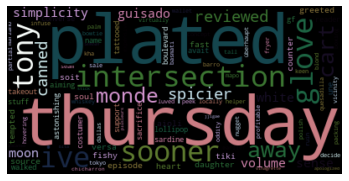

In [271]:
from itertools import cycle
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt

cmaps = cycle([
            'flag', 'prism', 'ocean', 'gist_earth', 'terrain', 'gist_stern',
            'gnuplot', 'gnuplot2', 'CMRmap', 'cubehelix', 'brg', 'hsv',
            'gist_rainbow', 'rainbow', 'jet', 'nipy_spectral', 'gist_ncar'])

for cluster_id in (cluster_ids):
    col = next(cmaps);
    display_cloud(cluster_id, col)

## DBScan

In [ ]:
clustering = cluster.DBSCAN(eps=1, min_samples=2).fit(X)

# Create the map of clusters and words
words = model.wv.index2word
    
cluster_map = pd.DataFrame()
cluster_map['data_index'] = words
cluster_map['data_vector'] = list(X)
cluster_map['cluster'] = clustering.labels_

cluster_ids = list(set(clustering.labels_))


In [ ]:
print(cluster_ids)

for cluster_id in cluster_ids:
    print(cluster_map[cluster_map['cluster']==cluster_id])